<a href="https://colab.research.google.com/github/gurnoor6/opponent-modelling/blob/main/Opponent_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil, os
filename_train = 'trout_logs'
filename_validation = 'trout_logs'
if os.path.exists(filename_train):
  shutil.rmtree(filename_train)
if os.path.exists(filename_validation):
  shutil.rmtree(filename_validation)
shutil.unpack_archive(f'{filename_train}.zip', './')
filenames = os.listdir(filename_train)
print(len(filenames))
filenames.sort()
train_filenames = filenames[:8500]
val_filenames = filenames[8500:]
print(train_filenames[0], val_filenames[0])

9456
304315.npz 430881.npz


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [3]:
# Constants
T = 8 # Number of Timesteps for which boards are present in input
N = 8 # board size
HIDDEN_LAYER = 1 # hidden layer will be N * N * HIDDEN_LAYER neurons long
OUTPUT_LAYER = 73 # output layer will be N * N * OUTPUT_LAYER neurons long
BLOCKS = 10
FILTERS = 128

In [4]:
import numpy as np

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, filenames, batch_size, randomize, folder_name) :
    self.filenames = filenames
    self.batch_size = batch_size
    self.randomize = randomize
    self.folder_name = folder_name
    self.boards_per_game = 4
    
    
  def __len__(self) :
    return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    filenames = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    inputs = []
    outputs = []
    legal_moves = []
    for f in filenames:
      if not f.endswith('.npz'): continue
      loaded = np.load(os.path.join(self.folder_name, f))
      length = len(loaded['inputs'])
      index = np.random.choice(length, length,replace=False)
      if self.randomize:
        index = np.random.choice(length, min(self.boards_per_game, length), replace = False)
      inputs.extend(loaded['inputs'][index])
      outputs.extend(loaded['outputs'][index])
      legal_moves.extend(loaded['legal_moves'][index])
    
    # Y_new = []
    # for item in outputs: Y_new.append(item.flatten())
    
    # print(np.array(inputs).shape, np.array(Y_new).shape)
    return (np.array(inputs), np.array(legal_moves)), np.array(outputs)

In [5]:
batch_size = 32

training_generator = My_Custom_Generator(train_filenames, batch_size, True, filename_train)
validation_generator = My_Custom_Generator(val_filenames, batch_size, False, filename_validation)

In [6]:
inputs = tf.keras.Input(shape=(112, 8, 8))
legal_moves_input = tf.keras.Input(shape = (1858))
x1 = tf.keras.layers.LeakyReLU()(inputs)


x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", data_format = 'channels_first')(x1)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(112, (3, 3), activation="relu", padding="same", data_format = 'channels_first')(x)
x = tf.keras.layers.BatchNormalization()(x)

added = tf.keras.layers.add([x1, x])
x = tf.keras.layers.LeakyReLU()(added)

x = tf.keras.layers.Conv2D(10, (3,3),activation="relu", padding="same", data_format = 'channels_first')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1858, activation = 'relu')(x)


# x = tf.keras.layers.add([x, legal_moves_input])

x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs = [inputs, legal_moves_input], outputs = x)
model.summary()
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 8, 8)]  0           []                               
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 112, 8, 8)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 8, 8)    129152      ['leaky_re_lu[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 8, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                   

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [8]:
history = model.fit_generator(generator=training_generator,
                   steps_per_epoch = int(len(train_filenames) // batch_size),
                   epochs = 10,
                   verbose = 1,
                   validation_data = validation_generator,
                   validation_steps = int(min(1000, len(val_filenames)) // batch_size)  # Use only 1000 samples for validation
                  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
265/265 [==============================] - 144s 522ms/step - loss: 4.4478 - categorical_accuracy: 0.3003 - val_loss: 5.4633 - val_categorical_accuracy: 0.2734
Epoch 2/10
265/265 [==============================] - 136s 512ms/step - loss: 3.8970 - categorical_accuracy: 0.3720 - val_loss: 4.6565 - val_categorical_accuracy: 0.3007
Epoch 3/10
265/265 [==============================] - 135s 510ms/step - loss: 3.7477 - categorical_accuracy: 0.3979 - val_loss: 4.5640 - val_categorical_accuracy: 0.3142
Epoch 4/10
265/265 [==============================] - 136s 513ms/step - loss: 3.6813 - categorical_accuracy: 0.4086 - val_loss: 4.5435 - val_categorical_accuracy: 0.3235
Epoch 5/10
265/265 [==============================] - 137s 517ms/step - loss: 3.5857 - categorical_accuracy: 0.4206 - val_loss: 4.5009 - val_categorical_accuracy: 0.3236
Epoch 6/10
265/265 [==============================] - 135s 512ms/step - loss: 3.5728 - categorical_accuracy: 0.4234 - val_loss: 4.4613 - val_categoric

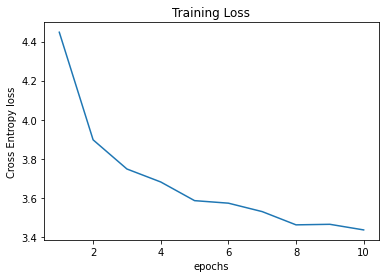

In [9]:
# Plot the loss a sa function of number of epochs
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['loss'])))),  history.history['loss'])

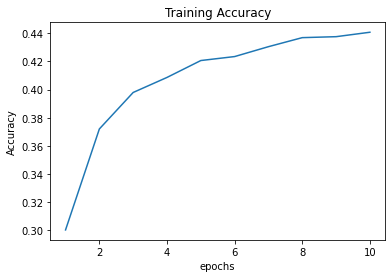

In [10]:
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['categorical_accuracy'])))),  history.history['categorical_accuracy'])

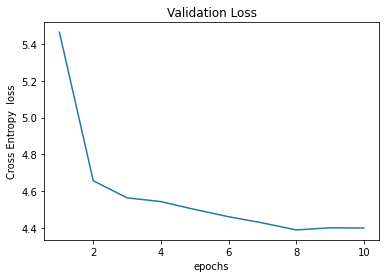

In [11]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy  loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_loss'])))),  history.history['val_loss'])

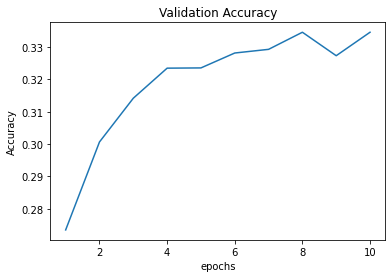

In [12]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_categorical_accuracy'])))),  history.history['val_categorical_accuracy'])

In [13]:
print(history.history)

{'loss': [4.447775363922119, 3.896965503692627, 3.747673511505127, 3.6812503337860107, 3.5857009887695312, 3.572762966156006, 3.5295612812042236, 3.4617538452148438, 3.464568853378296, 3.435835361480713], 'categorical_accuracy': [0.3003300428390503, 0.37199780344963074, 0.3979036808013916, 0.40857553482055664, 0.42056846618652344, 0.4233895540237427, 0.43040913343429565, 0.4368181526660919, 0.4375038146972656, 0.440651535987854], 'val_loss': [5.4632887840271, 4.65654993057251, 4.564028263092041, 4.543471336364746, 4.500876426696777, 4.461265563964844, 4.4278740882873535, 4.389632225036621, 4.400974273681641, 4.399864673614502], 'val_categorical_accuracy': [0.2734487056732178, 0.3006575405597687, 0.3141863942146301, 0.3234827220439911, 0.3235583007335663, 0.32816869020462036, 0.3293024003505707, 0.3345929980278015, 0.3273373246192932, 0.3345929980278015]}


In [14]:
from google.colab import files

folder_name = "saved-model"

if os.path.exists(folder_name):
  shutil.rmtree(folder_name)
os.mkdir(folder_name)

if os.path.exists(folder_name + ".zip"):
  os.remove(folder_name + ".zip")
model.save(folder_name)

shutil.make_archive(folder_name, 'zip', folder_name)
files.download(folder_name + ".zip")

INFO:tensorflow:Assets written to: saved-model/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>